In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
def gaussian(v,v0):
    sigma = 0.12*v0+0.896 # IEC standard class A
    return np.exp(-0.5*((v-v0)/sigma)**2)/sigma/np.sqrt(2*np.pi)

class Wind_Turbine:
    def __init__(self, rated_power, cutin_speed, rated_speed, cutout_speed, power, velocity):
        self.rated_power = rated_power
        self.cutin_speed = cutin_speed
        self.rated_speed = rated_speed
        self.cutout_speed = cutout_speed
        self.partial_pc = interpolate.interp1d(velocity, power, 'cubic', fill_value = 'extrapolate')
    
    def single_pc(self, v):
        v = abs(v)
        return (0.*(v<=self.cutin_speed) + self.partial_pc(v)*(v>self.cutin_speed)*(v<=self.rated_speed)
                + self.rated_power*(v>self.rated_speed)*(v<=self.cutout_speed) + 0.*(v>self.cutout_speed))
    
    def multi_pc(self, v0):
        return integrate.quad_vec(lambda v: self.single_pc(v)*gaussian(v,v0), -np.inf, np.inf)[0]

In [3]:
# Vestas V164/8000
P = [0,40,100,370,650,895,1150,1500,1850,2375,2900,3525,4150,4875,5600,6350,7100,7580,7800,7920,8000] # kW
v = np.arange(3,13.5,0.5) # m/s
vestas = Wind_Turbine(8000,3,13,25,P,v)

# Enercon E126/7500
P = [0,25,55,110,175,290,410,580,760,1005,1250,1575,1900,2300,2700,3225,3750,
     4300,4850,5300,5750,6125,6500,6780,7000,7200,7350,7450,7500,7560,7580] # kW
v = np.arange(2,17.5,0.5) # m/s
enercon = Wind_Turbine(7580,2,17,25,P,v)

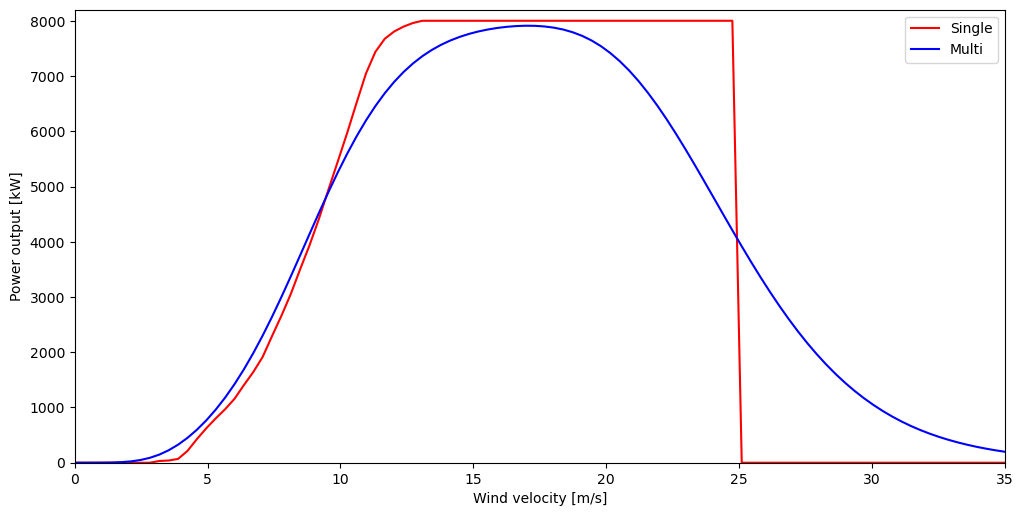

In [4]:
x = np.linspace(0,35,100)
plt.figure(figsize = (12,6), dpi = 100)
plt.plot(x, vestas.single_pc(x), c = 'r', label = 'Single')
plt.plot(x, vestas.multi_pc(x), c = 'b', label = 'Multi')
#plt.scatter(wind_ninja['wind_speed'], wind_ninja['electricity'], s = 1.5, c = 'g', label = 'Ninja')
plt.xlabel('Wind velocity [m/s]')
plt.ylabel('Power output [kW]')
plt.xlim([0,35])
plt.ylim([0,8200])
plt.legend()
plt.show()

In [5]:
plants = pd.read_csv('data/plants/plants.csv', sep = ';', index_col = 0, comment = '#')

for i in plants.index:
    wind_ninja = pd.read_csv('data/wind/ninja_wind_%s.csv'%plants['location'][i],
                             sep = ',',
                             index_col = 0,
                             usecols = [0,2,3],
                             comment = '#')
    v = wind_ninja['wind_speed'].values/wind_ninja['wind_speed'].mean()*plants['atlas_wind_speed'][i]
    if plants['onshore'][i]:
        P = enercon.multi_pc(v)
        cf_wind = P/enercon.rated_power
    else:
        P = vestas.multi_pc(v)
        cf_wind = P/vestas.rated_power
    pd.Series(cf_wind).to_csv('data/cf/wind_%s.csv'%plants['location'][i])